In [1]:
import json
import pandas as pd
import h5py
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU,TimeDistributed, Conv1D, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
import os
import h5py
import matplotlib.pyplot as plt
from keras import regularizers
from tensorflow.keras.regularizers import l1
import ast
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from pandas import read_csv
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_auc_score
from qkeras import *
import qkeras
from tensorflow.keras.models import load_model
from qkeras.utils import model_quantize
from qkeras.utils import model_save_quantized_weights

import matplotlib.pyplot as plt

In [5]:
# from google.colab import drive
# drive.mount('/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
# X_train = np.load('/drive/Shareddrives/Jet Classification/Data/Quickdraw/X_train.npy', allow_pickle=True)
# X_test = np.load('/drive/Shareddrives/Jet Classification/Data/Quickdraw/X_test.npy', allow_pickle=True)
# y_train = np.load('/drive/Shareddrives/Jet Classification/Data/Quickdraw/y_train.npy', allow_pickle=True)
# y_test = np.load('/drive/Shareddrives/Jet Classification/Data/Quickdraw/y_test.npy', allow_pickle=True)

## Load Training and Testing data

In [37]:
X_train = np.load('./X_train.npy', allow_pickle=True)
X_test = np.load('./X_test.npy', allow_pickle=True)
y_train = np.load('./y_train.npy', allow_pickle=True)
y_test = np.load('./y_test.npy', allow_pickle=True)

print(X_train.shape)

X_trainzero = np.zeros((242263,100,3))

for x in tqdm(range(len(X_train))):
#     print(len(X_train[x]))
  for y in range(100):
    for z in range(3):
      if y >= len(X_train[x]):
        break
      else:
        X_trainzero[x][y][z] = X_train[x][y][z]
        
y_labhot = np.zeros((len(y_train),5))

y_labhot.shape

num = 0
for x in y_train:
  if x == 0:
    y_labhot[num][0] = 1
  elif x == 1: 
    y_labhot[num][1] = 1
  elif x == 2: 
    y_labhot[num][2] = 1
  elif x == 3: 
    y_labhot[num][3] = 1
  elif x == 4: 
    y_labhot[num][4] = 1
  num = num + 1

y_labhot

(242263,)


100%|████████████████████████████████████████████████████████████████████████| 242263/242263 [00:43<00:00, 5594.08it/s]


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [38]:
print("x-shape: ", X_trainzero.shape)

x-shape:  (242263, 100, 3)


In [3]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):

        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
        
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

In [4]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

In [5]:
X_testzero = np.zeros((len(X_test),100,3))

X_testzero[0][0][0]

for x in tqdm(range(len(X_test))):
  for y in range(100):
    for z in range(3):
      if y >= len(X_test[x]):
        break
      else:
        X_testzero[x][y][z] = X_test[x][y][z]
        
y_tlabhot = np.zeros((len(y_test),5))

num = 0
for x in y_test:
  if x == 0:
    y_tlabhot[num][0] = 1
  elif x == 1: 
    y_tlabhot[num][1] = 1
  elif x == 2: 
    y_tlabhot[num][2] = 1
  elif x == 3: 
    y_tlabhot[num][3] = 1
  elif x == 4: 
    y_tlabhot[num][4] = 1
  num = num + 1

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:02<00:00, 5092.53it/s]


In [18]:
shuffler = np.random.permutation(len(X_trainzero))
array1_shuffled = X_trainzero[shuffler]
array2_shuffled = y_labhot[shuffler]

## Short sequency test

In [23]:
# X_train = np.load('./X_train.npy', allow_pickle=True)
# X_test = np.load('./X_test.npy', allow_pickle=True)
# y_train = np.load('./y_train.npy', allow_pickle=True)
# y_test = np.load('./y_test.npy', allow_pickle=True)

# print(X_train.shape)

# X_trainzero = np.zeros((242263,20,3))

# for x in tqdm(range(len(X_train))):
# #     print(len(X_train[x]))
#   for y in range(100):
#     for z in range(3):
#       if y >= len(X_train[x]) or y >= 20:
#         break
#       else:
#         X_trainzero[x][y][z] = X_train[x][y][z]
        
# y_labhot = np.zeros((len(y_train),5))

# y_labhot.shape

# num = 0
# for x in y_train:
#   if x == 0:
#     y_labhot[num][0] = 1
#   elif x == 1: 
#     y_labhot[num][1] = 1
#   elif x == 2: 
#     y_labhot[num][2] = 1
#   elif x == 3: 
#     y_labhot[num][3] = 1
#   elif x == 4: 
#     y_labhot[num][4] = 1
#   num = num + 1

# y_labhot

(242263,)


100%|███████████████████████████████████████████████████████████████████████| 242263/242263 [00:21<00:00, 11203.59it/s]


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [25]:
# X_trainzero.shape

(242263, 20, 3)

In [26]:
# X_testzero = np.zeros((len(X_test),20,3))

# X_testzero[0][0][0]

# for x in tqdm(range(len(X_test))):
#   for y in range(100):
#     for z in range(3):
#       if y >= len(X_test[x]) or y >= 20:
#         break
#       else:
#         X_testzero[x][y][z] = X_test[x][y][z]
        
# y_tlabhot = np.zeros((len(y_test),5))

# num = 0
# for x in y_test:
#   if x == 0:
#     y_tlabhot[num][0] = 1
#   elif x == 1: 
#     y_tlabhot[num][1] = 1
#   elif x == 2: 
#     y_tlabhot[num][2] = 1
#   elif x == 3: 
#     y_tlabhot[num][3] = 1
#   elif x == 4: 
#     y_tlabhot[num][4] = 1
#   num = num + 1

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 11033.54it/s]


In [27]:
# shuffler = np.random.permutation(len(X_trainzero))
# array1_shuffled = X_trainzero[shuffler]
# array2_shuffled = y_labhot[shuffler]

In [33]:
# Inputs = Input(shape = (20,3))
# x = Conv1D(128,(6))(Inputs)
# x = Activation('relu', name = 'relu_0')(x)
# x = Conv1D(64,(3))(x)
# x = Activation('relu', name = 'relu_1')(x)
# x = Conv1D(1, (1))(x)
# x = Activation('relu', name = 'relu_2')(x)
# x = LSTM(128, return_sequences=True, name='lstm_10')(x)
# x = Dropout(rate = 0.5)(x)
# x = LSTM(64, return_sequences=False, name='lstm_11')(x)
# predictions = Dense(5, kernel_initializer='lecun_uniform', name='rnn_densef')(x)
# predictions = Activation('softmax', name = 'output_softmax')(predictions)
# model = Model(inputs=Inputs, outputs=predictions)

# model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 20, 3)]           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 15, 128)           2432      
                                                                 
 relu_0 (Activation)         (None, 15, 128)           0         
                                                                 
 conv1d_22 (Conv1D)          (None, 13, 64)            24640     
                                                                 
 relu_1 (Activation)         (None, 13, 64)            0         
                                                                 
 conv1d_23 (Conv1D)          (None, 13, 1)             65        
                                                                 
 relu_2 (Activation)         (None, 13, 1)             0   

In [34]:
# adam = Adam(lr = 0.001)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(array1_shuffled, array2_shuffled, batch_size = 512, epochs = 50, 
#                     validation_split = 0.2, shuffle = True, callbacks = None,
#                     use_multiprocessing=True, workers=4)
# labels = ['ant', 'bee', 'butterfly', 'mosquito', 'snail']
# y_pred = makeRoc(X_testzero, y_tlabhot, labels, model, outputSuffix='two-layer')
# y_keras = model.predict(X_testzero, batch_size=512)
# auc_score = roc_auc_score(y_tlabhot, y_keras)
# print(auc_score)

Epoch 1/50
152/379 [===========>..................] - ETA: 2s - loss: 0.6556 - accuracy: 0.7795

KeyboardInterrupt: 

In [35]:
# for i in [6]:
#     for j in [8]:
#         int_bits = i
#         total_bits = i+j+1
#         config = {
#             "lstm_10":{
#                 "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
#                  "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
#                  "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
#                  "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
#             },
#             "lstm_11":{
#                 "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
#                  "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
#                  "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
#                  "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
#             },
#             "QDense":{
#                 "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
#                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
#             },
#             "QConv1D":{
#                 "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
#                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
#             },
#             "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
#             "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
#             "relu_2" : f"quantized_relu({total_bits},{int_bits},1)",
#         }
#         qmodel = model_quantize(model, config, total_bits, transfer_weights=False)
#         qmodel.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 20, 3)]           0         
                                                                 
 conv1d_21 (QConv1D)         (None, 15, 128)           2432      
                                                                 
 relu_0 (QActivation)        (None, 15, 128)           0         
                                                                 
 conv1d_22 (QConv1D)         (None, 13, 64)            24640     
                                                                 
 relu_1 (QActivation)        (None, 13, 64)            0         
                                                                 
 conv1d_23 (QConv1D)         (None, 13, 1)             65        
                                                                 
 relu_2 (QActivation)        (None, 13, 1)             0   

Epoch 1/50
379/379 [==============================] - 102s 246ms/step - loss: 0.5971 - accuracy: 0.8031 - val_loss: 0.5111 - val_accuracy: 0.8384
Epoch 2/50
379/379 [==============================] - 93s 245ms/step - loss: 0.5005 - accuracy: 0.8412 - val_loss: 0.4816 - val_accuracy: 0.8459
Epoch 3/50
379/379 [==============================] - 91s 241ms/step - loss: 0.4716 - accuracy: 0.8526 - val_loss: 0.4501 - val_accuracy: 0.8607
Epoch 4/50
379/379 [==============================] - 88s 232ms/step - loss: 0.4495 - accuracy: 0.8588 - val_loss: 0.4335 - val_accuracy: 0.8643
Epoch 5/50
379/379 [==============================] - 92s 243ms/step - loss: 0.4319 - accuracy: 0.8642 - val_loss: 0.4292 - val_accuracy: 0.8660
Epoch 6/50
379/379 [==============================] - 89s 235ms/step - loss: 0.4187 - accuracy: 0.8686 - val_loss: 0.4112 - val_accuracy: 0.8709
Epoch 7/50
379/379 [==============================] - 93s 245ms/step - loss: 0.4085 - accuracy: 0.8714 - val_loss: 0.4016 - val_a

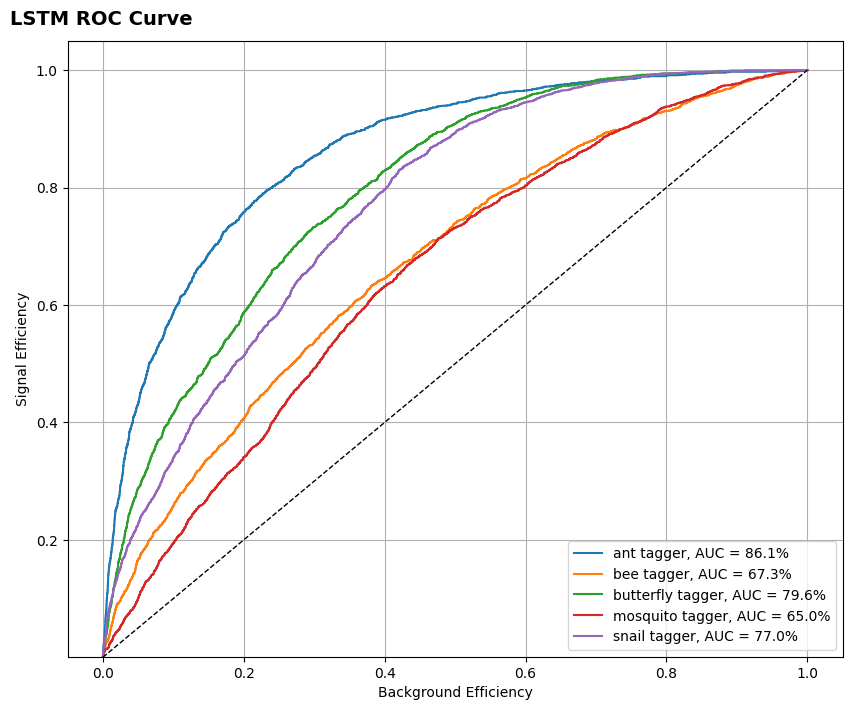

In [36]:
# adam = Adam(lr = 0.001)
# qmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history = qmodel.fit(array1_shuffled, array2_shuffled, batch_size = 512, epochs = 50, 
#                     validation_split = 0.2, shuffle = True, callbacks = None,
#                     use_multiprocessing=True, workers=4)
# labels = ['ant', 'bee', 'butterfly', 'mosquito', 'snail']
# y_pred = makeRoc(X_testzero, y_tlabhot, labels, model, outputSuffix='two-layer')
# y_keras = qmodel.predict(X_testzero, batch_size=512)
# auc_score = roc_auc_score(y_tlabhot, y_keras)
# print(auc_score)

In [7]:
# Inputs = Input(shape = (100,3))
# x = Conv1D(128,(6),activation='relu')(Inputs)
# x = Conv1D(64,(3),activation='relu')(x)
# x = Conv1D(1, (1), activation='relu')(x)
# x = LSTM(128, return_sequences=True)(x)
# x = Dropout(rate = 0.5)(x)
# x = LSTM(64, return_sequences=False)(x)
# predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
# model = Model(inputs=Inputs, outputs=predictions)

# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 95, 128)           2432      
                                                                 
 conv1d_1 (Conv1D)           (None, 93, 64)            24640     
                                                                 
 conv1d_2 (Conv1D)           (None, 93, 1)             65        
                                                                 
 lstm (LSTM)                 (None, 93, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 93, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408 

## Models

## LSTM

In [13]:
Inputs = Input(shape = (100,3))
x = Conv1D(128,(6))(Inputs)
x = Activation('relu', name = 'relu_0')(x)
x = Conv1D(64,(3))(x)
x = Activation('relu', name = 'relu_1')(x)
x = Conv1D(1, (1))(x)
x = Activation('relu', name = 'relu_2')(x)
x = LSTM(128, return_sequences=True, name='lstm_10')(x)
x = Dropout(rate = 0.5)(x)
x = LSTM(64, return_sequences=False, name='lstm_11')(x)
predictions = Dense(5, kernel_initializer='lecun_uniform', name='rnn_densef')(x)
predictions = Activation('softmax', name = 'output_softmax')(predictions)
lstm = Model(inputs=Inputs, outputs=predictions)

lstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 95, 128)           2432      
                                                                 
 relu_0 (Activation)         (None, 95, 128)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 93, 64)            24640     
                                                                 
 relu_1 (Activation)         (None, 93, 64)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 93, 1)             65        
                                                                 
 relu_2 (Activation)         (None, 93, 1)             0   

## GRU

In [ ]:
Inputs = Input(shape = (100,3))

x = GRU(32, return_sequences=True)(Inputs)
x = Flatten()(x)
x = Dense(32)(x)
x = Activation('relu', name = 'relu_0')(x)
x = Dropout(rate = 0.5)(x)
x = Dense(16)(x)
x = Activation('relu', name = 'relu_1')(x)
predictions = Dense(5, kernel_initializer='lecun_uniform', name='rnn_densef')(x)
predictions = Activation('softmax', name = 'softmax')(predictions)
gru = Model(inputs=Inputs, outputs=predictions)

gru.summary()

## LSTM Floating Point Model Training

In [9]:
adam = Adam(lr = 0.001)
lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = lstm.fit(array1_shuffled, array2_shuffled, batch_size = 512, epochs = 50, 
                    validation_split = 0.2, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)
labels = ['ant', 'bee', 'butterfly', 'mosquito', 'snail']
y_pred = makeRoc(X_testzero, y_tlabhot, labels, lstm, outputSuffix='two-layer')
y_keras = lstm.predict(X_testzero, batch_size=512)
auc_score = roc_auc_score(y_tlabhot, y_keras)
print(auc_score)
model.save('./lstm/Quickdraw5Class1.h5')

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
 79/379 [=====>........................] - ETA: 9s - loss: 0.9916 - accuracy: 0.5344

KeyboardInterrupt: 

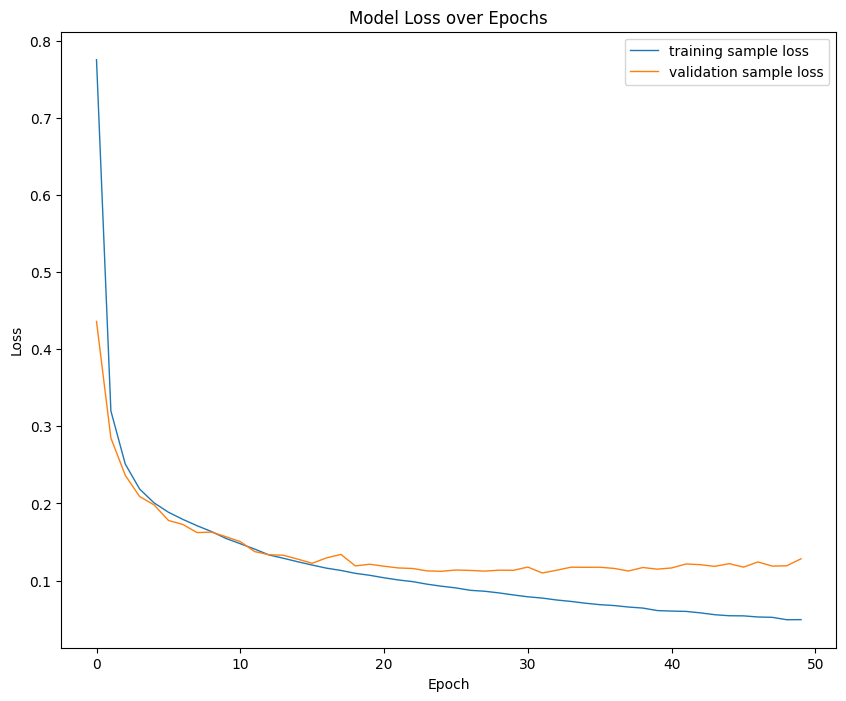

In [26]:
learningCurve(history)

## GRU Floating Point Model Training

In [ ]:
adam = Adam(lr = 0.001)
gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = gru.fit(array1_shuffled, array2_shuffled, batch_size = 512, epochs = 50, 
                    validation_split = 0.2, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)
labels = ['ant', 'bee', 'butterfly', 'mosquito', 'snail']
y_pred = makeRoc(X_testzero, y_tlabhot, labels, gru, outputSuffix='two-layer')
y_keras = gru.predict(X_testzero, batch_size=512)
auc_score = roc_auc_score(y_tlabhot, y_keras)
print(auc_score)
model.save('./gru/Quickdraw5Class1.h5')

In [ ]:
learningCurve(history)

## QLSTM Quantization Aware Training

In [14]:
for i in [2, 4]:
    for j in [2, 4, 6, 8, 10, 12, 14, 16, 18]:
        int_bits = i
        total_bits = i+j+1
        config = {
            "lstm_10":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "lstm_11":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QConv1D":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_2" : f"quantized_relu({total_bits},{int_bits},1)",
#             "QActivation":{
#                 f"quantized_bits({total_bits},{int_bits},1)"
#             }
        }
        qlstm = model_quantize(lstm, config, total_bits, transfer_weights=False)
        qlstm.summary()
        adam = Adam(lr = 0.001)
        qlstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = qlstm.fit(array1_shuffled, array2_shuffled, batch_size = 512, epochs = 50, 
                            validation_split = 0.2, shuffle = True, callbacks = None,
                            use_multiprocessing=True, workers=4)

        y_keras = qlstm.predict(X_testzero, batch_size=512)
        auc_score = roc_auc_score(y_tlabhot, y_keras)
        print(auc_score)
        model.save(f'./qlstm_{i}int/qlstm_{j}frac.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 conv1d_9 (QConv1D)          (None, 95, 128)           2432      
                                                                 
 relu_0 (QActivation)        (None, 95, 128)           0         
                                                                 
 conv1d_10 (QConv1D)         (None, 93, 64)            24640     
                                                                 
 relu_1 (QActivation)        (None, 93, 64)            0         
                                                                 
 conv1d_11 (QConv1D)         (None, 93, 1)             65        
                                                                 
 relu_2 (QActivation)        (None, 93, 1)             0   

In [ ]:
labels = ['ant', 'bee', 'butterfly', 'mosquito', 'snail']
y_pred = makeRoc(X_testzero, y_tlabhot, labels, qlstm, outputSuffix='two-layer')

## QGRU Quantization Aware Training

In [ ]:
for i in [2, 4]:
    for j in [2, 4, 6, 8, 10, 12, 14, 16, 18]:
        int_bits = i
        total_bits = i+j+1
        config = {
            "QGRU":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QConv1D":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)"
        }
        qgru = model_quantize(gru, config, total_bits, transfer_weights=False)
        qgru.summary()     
        
        adam = Adam(lr = 0.001)
        qgru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = qgru.fit(array1_shuffled, array2_shuffled, batch_size = 256, epochs = 50, 
                            validation_split = 0.2, shuffle = True, callbacks = None,
                            use_multiprocessing=True, workers=4)
# labels = ['ant', 'bee', 'butterfly', 'mosquito', 'snail']
# y_pred = makeRoc(X_testzero, y_tlabhot, labels, qgru, outputSuffix='two-layer')
        y_keras = qgru.predict(X_testzero, batch_size=512)
        auc_score = roc_auc_score(y_tlabhot, y_keras)
        print(auc_score)
        model.save(f'./qgru_{i}int/qgru_{j}frac.h5')

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
379/379 [==============================] - 22s 47ms/step - loss: 0.5675 - accuracy: 0.7958 - val_loss: 0.3053 - val_accuracy: 0.9122
Epoch 2/50
379/379 [==============================] - 16s 43ms/step - loss: 0.2700 - accuracy: 0.9202 - val_loss: 0.2436 - val_accuracy: 0.9272
Epoch 3/50
379/379 [==============================] - 16s 43ms/step - loss: 0.2265 - accuracy: 0.9316 - val_loss: 0.2121 - val_accuracy: 0.9350
Epoch 4/50
379/379 [==============================] - 16s 43ms/step - loss: 0.2036 - accuracy: 0.9373 - val_loss: 0.1929 - val_accuracy: 0.9396
Epoch 5/50
379/379 [==============================] - 16s 42ms/step - loss: 0.1819 - accuracy: 0.9432 - val_loss: 0.1711 - val_accuracy: 0.9459
Epoch 6/50
379/379 [==============================] - 16s 43ms/step - loss: 0.1680 - accuracy: 0.9471 - val_loss: 0.1658 - val_accuracy: 0.9480
Epoch 7/50
379/379 [==============================] - 16s 43ms/step - loss: 0.1552 - accuracy: 0.9506 - val_loss: 0.1552 - val_accuracy:

In [ ]:
labels = ['ant', 'bee', 'butterfly', 'mosquito', 'snail']
y_pred = makeRoc(X_testzero, y_tlabhot, labels, qgru, outputSuffix='two-layer')

## QLSTM Post Training Quantization

In [9]:
lstm = load_model('./lstm/Quickdraw5Class1.h5')

In [17]:
lstm.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 conv1d_15 (Conv1D)          (None, 95, 128)           2432      
                                                                 
 relu_0 (Activation)         (None, 95, 128)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 93, 64)            24640     
                                                                 
 relu_1 (Activation)         (None, 93, 64)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 93, 1)             65        
                                                                 
 relu_2 (Activation)         (None, 93, 1)             0   

In [15]:
for i in [2, 4]:
    for j in [2, 4, 6, 8, 10, 12, 14, 16, 18]:
        int_bits = i
        total_bits = i+j+1
        config = {

            "lstm_10":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "lstm_11":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QConv1D":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_2" : f"quantized_relu({total_bits},{int_bits},1)",
#             "QActivation":{
#                 f"quantized_bits({total_bits},{int_bits},1)"
#             }
        }
        qlstm = model_quantize(lstm, config, total_bits, transfer_weights=True)

        qlstm.summary()

        for layer in qlstm.layers:
            if hasattr(layer, "recurrent_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
            elif hasattr(layer, "kernel_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
            elif hasattr(layer, "quantized_relu"):
                print(layer.name, "quantized_relu:", str(layer.quantizer))
#             else:
#                 print(layer.name)
                

        y_keras = qlstm.predict(X_testzero, batch_size=2**10)
        auc_score = roc_auc_score(y_tlabhot, y_keras)
        print("AUC score:", auc_score)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 conv1d_15 (QConv1D)         (None, 95, 128)           2432      
                                                                 
 relu_0 (QActivation)        (None, 95, 128)           0         
                                                                 
 conv1d_16 (QConv1D)         (None, 93, 64)            24640     
                                                                 
 relu_1 (QActivation)        (None, 93, 64)            0         
                                                                 
 conv1d_17 (QConv1D)         (None, 93, 1)             65        
                                                                 
 relu_2 (QActivation)        (None, 93, 1)             0   

In [11]:
model_save_quantized_weights(qlstm, f"ptq{i}int{j}fra_weight")

... quantizing model


{'conv1d_15': {'weights': [array([[[ 0.    ,  0.    ,  0.0625, ...,  0.125 ,  0.25  , -0.125 ],
           [ 0.    ,  0.    ,  0.0625, ..., -0.125 ,  0.    ,  0.    ],
           [-1.75  ,  0.75  ,  0.375 , ...,  1.    ,  0.25  ,  1.5   ]],
   
          [[-0.25  , -0.25  ,  0.    , ...,  0.    ,  0.    ,  0.    ],
           [ 0.    ,  0.    ,  0.0625, ...,  0.    ,  0.    ,  0.125 ],
           [ 2.75  ,  2.25  ,  0.125 , ..., -0.375 , -3.75  ,  0.875 ]],
   
          [[-0.25  ,  0.    ,  0.    , ...,  0.25  ,  0.25  ,  0.    ],
           [ 0.25  ,  0.    ,  0.125 , ..., -0.125 ,  0.    ,  0.    ],
           [-1.75  , -3.25  ,  0.4375, ..., -1.875 , -1.5   , -1.25  ]],
   
          [[ 0.    ,  0.    , -0.0625, ...,  0.    ,  0.    ,  0.    ],
           [ 0.    ,  0.    ,  0.125 , ...,  0.    ,  0.    ,  0.    ],
           [ 1.    ,  1.    ,  0.9375, ...,  0.625 ,  0.    , -0.125 ]],
   
          [[ 0.    ,  0.    ,  0.0625, ...,  0.    ,  0.    ,  0.125 ],
           [ 0.    ,

## QGRU Post Training Quantization

In [ ]:
gru = load_model('./gru/Quickdraw5Class1.h5')

In [ ]:
gru.summary()

In [ ]:
for i in [2, 4]:
    for j in [2, 4, 6, 8, 10, 12, 14, 16, 18]:
        int_bits = i
        total_bits = i+j+1
        config = {
            "QGRU":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QConv1D":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)"
        }
        qgru = model_quantize(gru, config, total_bits, transfer_weights=False)
        qgru.summary()  


        for layer in qgru.layers:
            if hasattr(layer, "recurrent_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
            elif hasattr(layer, "kernel_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
            elif hasattr(layer, "quantized_relu"):
                print(layer.name, "quantized_relu:", str(layer.quantizer))
        

        y_keras = qgru.predict(X_testzero, batch_size=512)
        auc_score = roc_auc_score(y_tlabhot, y_keras)
        print("AUC score:", auc_score)

In [ ]:
model_save_quantized_weights(qgru, f"ptq{i}int{j}fra_weight")

## Check the train and test data

In [ ]:

ant = 0
bee = 0
butterfly = 0
mosquito = 0
snail = 0
for x in y_test:
  if x == 0:
    ant = ant + 1
  elif x == 1:
    bee = bee + 1
  elif x == 2:
    butterfly = butterfly+ 1
  elif x==3:
    mosquito = mosquito + 1
  elif x ==4:
    snail = snail + 1 

In [ ]:
print(ant)
print(bee)
print(butterfly)
print(mosquito)
print(snail)

2500
2500
2500
2500
2500


In [ ]:

ant = 0
bee = 0
butterfly = 0
mosquito = 0
snail = 0
for x in y_train:
  if x == 0:
    ant = ant + 1
  elif x == 1:
    bee = bee + 1
  elif x == 2:
    butterfly = butterfly+ 1
  elif x==3:
    mosquito = mosquito + 1
  elif x ==4:
    snail = snail + 1 

In [ ]:
print(ant)
print(bee)
print(butterfly)
print(mosquito)
print(snail)

110687
107059
104288
108399
119076


## No need to run this part 

In [27]:
Inputs = Input(shape = (100,3))

x = GRU(32, return_sequences=True)(Inputs)
x = Flatten()(x)
x = Dense(32)(x)
x = Activation('relu', name = 'relu_0')(x)
x = Dropout(rate = 0.5)(x)
x = Dense(16)(x)
x = Activation('relu', name = 'relu_1')(x)
predictions = Dense(5, kernel_initializer='lecun_uniform', name='rnn_densef')(x)
predictions = Activation('softmax', name = 'softmax')(predictions)
model = Model(inputs=Inputs, outputs=predictions)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 gru_1 (GRU)                 (None, 100, 32)           3552      
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                102432    
                                                                 
 relu_0 (Activation)         (None, 32)                0         
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528 

In [32]:
adam = Adam(lr = 0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [33]:
history = model.fit(array1_shuffled, array2_shuffled, batch_size = 512, epochs = 50, 
                    validation_split = 0.2, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/50
379/379 [==============================] - 6s 12ms/step - loss: 0.4728 - accuracy: 0.8468 - val_loss: 0.2496 - val_accuracy: 0.9245
Epoch 2/50
379/379 [==============================] - 4s 11ms/step - loss: 0.2711 - accuracy: 0.9187 - val_loss: 0.2190 - val_accuracy: 0.9323
Epoch 3/50
379/379 [==============================] - 4s 11ms/step - loss: 0.2319 - accuracy: 0.9300 - val_loss: 0.1817 - val_accuracy: 0.9423
Epoch 4/50
379/379 [==============================] - 4s 11ms/step - loss: 0.2052 - accuracy: 0.9378 - val_loss: 0.1658 - val_accuracy: 0.9481
Epoch 5/50
379/379 [==============================] - 4s 11ms/step - loss: 0.1896 - accuracy: 0.9409 - val_loss: 0.1652 - val_accuracy: 0.9466
Epoch 6/50
379/379 [==============================] - 4s 11ms/step - loss: 0.1771 - accuracy: 0.9438 - val_loss: 0.1500 - val_accuracy: 0.9526
Epoch 7/50
379/379 [==============================] - 4s 11ms/step - loss: 0.1675 - accuracy: 0.9460 - val_loss: 0.1485 - val_accuracy: 0.9551

391/391 [==============================] - 2s 5ms/step


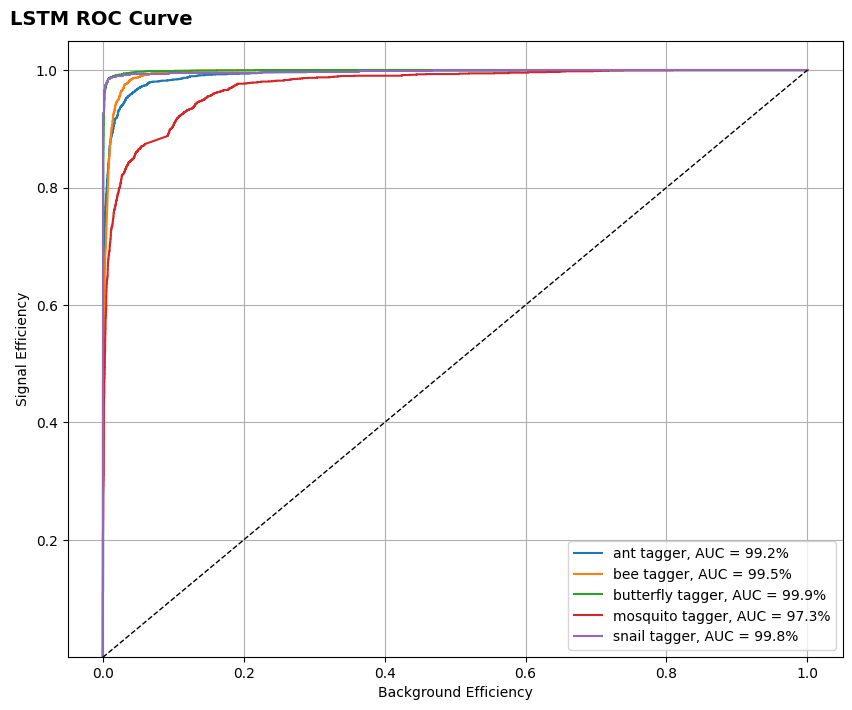

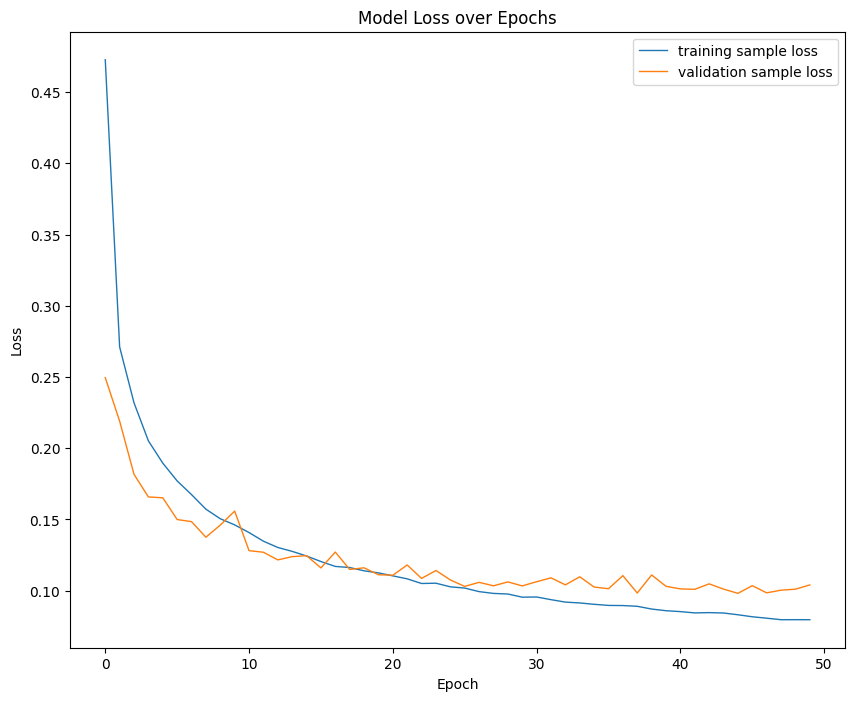

In [34]:
y_pred = makeRoc(X_testzero, y_tlabhot, labels, model, outputSuffix='two-layer')
learningCurve(history)

In [28]:
for i in [12]:
    for j in [19]:
        int_bits = i
        total_bits = i+j+1
        config = {
#             "QLSTM":{
            "QGRU":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QConv1D":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)"
        }
        qmodel = model_quantize(model, config, total_bits, transfer_weights=True)
        qmodel.summary()     
        
        adam = Adam(lr = 0.001)
        qmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = qmodel.fit(array1_shuffled, array2_shuffled, batch_size = 256, epochs = 50, 
                            validation_split = 0.2, shuffle = True, callbacks = None,
                            use_multiprocessing=True, workers=4)
# labels = ['ant', 'bee', 'butterfly', 'mosquito', 'snail']
# y_pred = makeRoc(X_testzero, y_tlabhot, labels, model, outputSuffix='two-layer')
        y_keras = qmodel.predict(X_testzero, batch_size=512)
        auc_score = roc_auc_score(y_tlabhot, y_keras)
        print(auc_score)
        model.save(f'./qgru_{i}int/lstm_{j}.h5')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 gru_1 (QGRU)                (None, 100, 32)           3552      
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_2 (QDense)            (None, 32)                102432    
                                                                 
 relu_0 (QActivation)        (None, 32)                0         
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (QDense)            (None, 16)                528 

KeyboardInterrupt: 

In [ ]:
PTQ2int = []
PTQ4int = []
from qkeras.utils import model_quantize
from qkeras.utils import model_save_quantized_weights
for i in [2, 4]:
    for j in [2, 4, 6, 8, 10, 12, 14]:
        int_bits = i
        total_bits = i+j+1
        config = {
            "QLSTM":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
        qmodel = model_quantize(lstm, config, total_bits, transfer_weights=True)

#         qmodel.summary()

        for layer in qmodel.layers:
            if hasattr(layer, "recurrent_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
            elif hasattr(layer, "kernel_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
            elif hasattr(layer, "quantized_relu"):
                print(layer.name, "quantized_relu:", str(layer.quantizer))
            else:
                print(layer.name)
                
#         model_save_quantized_weights(qmodel, f"ptq{i}int{j}fra_weight")
        y_keras = qmodel.predict(x_test, batch_size=2**10)
        auc_score = roc_auc_score(y_test, y_keras)
        print("AUC score:", auc_score)
        if i == 2:
            PTQ2int.append(auc_score)
        else:
            PTQ4int.append(auc_score)